In [1]:
import numpy as np
import dwave.inspector
from dwave.system import DWaveSampler
import pickle
import pandas as pd
from pathlib import Path  
from datetime import datetime
import matplotlib.pyplot as plt
import os
import dimod
import networkx as nx
import dwave_networkx as dnx

from shapely.geometry import Point, Polygon
from libpysal import weights, examples
from libpysal.cg import voronoi_frames
import geopandas as gpd
from minorminer import find_embedding


from matplotlib.pyplot import subplots
from matplotlib.table import Table
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.cm as cm
import matplotlib as mpl

import warnings
warnings.filterwarnings('ignore')


def set_params_array(paramsdict):
    paramsarray = np.array([list(paramsdict.keys()), list(paramsdict.values())])
    return paramsarray

def Random_Points_in_Bounds(polygon, number):   
    minx, miny, maxx, maxy = polygon.bounds
    x = np.random.uniform( minx, maxx, number )
    y = np.random.uniform( miny, maxy, number )
    return x, y

In [2]:

# Use a D-Wave system as the sampler
f = open("../token.txt", "r")
#sampler = DWaveSampler(solver=dict(topology__type='chimera'),token=f.read())
sampler = DWaveSampler(solver=dict(topology__type='zephyr'),token=f.read())

print("QPU {} was selected.".format(sampler.solver.name))

QPU Advantage2_prototype1.1 was selected.


In [3]:
#get the couplers and nodes available in the qpu
couplers_avail = np.array(sampler.edgelist)
nodes_avail = np.array(sampler.nodelist)

target_graph = nx.Graph()
target_graph.add_nodes_from(nodes_avail)
target_graph.add_edges_from(couplers_avail)

# load data

In [8]:
rep = 10
Npts = 20
beta = 1
data_extract = np.load('./data/raw/Npts={:.0f}/beta={}/forward_anneal_sol_{:.0f}.npz'.format(Npts, beta, rep), allow_pickle=True)


In [ ]:
def magnetization_per_sample(resps, embedding, variables):
    mags = []
    # broken = []
    num_broken = []
    mags_per_site = np.zeros(len(embedding))
    for k in range(len(resps)):
        ind_mag = 0
        ind_broken = 0
        for site in embedding.keys():
            embedding[site][0]
            if len(embedding[site]) == 2:
                site1 = np.where(variables == embedding[site][0])[0]
                site2 = np.where(variables == embedding[site][1])[0]
                if resps[k][site1] == resps[k][site2]:
                    # broken.append('good')
                    ind_mag += resps[k][site1]
                    mags_per_site[site] += resps[k][site1]
                else:
                    # broken.append('broken')
                    ind_broken += 1
                    ind_mag += 0
            else:
                # print(embedding[site])
                site1 = np.where(variables == embedding[site][0])[0]
                # print(site1)
                ind_mag += resps[k][site1]
                mags_per_site[site] += resps[k][site1]

            # site1 = np.where(variables == embedding[site][0])[0]
            # # print(site1)
            # ind_mag += resps[k][site1]

        # print(ind_mag)

        mags.append(ind_mag)
        num_broken.append(ind_broken)
    return mags, num_broken, mags_per_site/len(resps)

def energy_per_sample(resps, embedding, variables, all_edges):

    ene = []
    for k in range(len(resps)):
        ind_ene = 0
        for edge in all_edges:
            # if len(embedding[site]) == 2:
            site1 = np.where(variables == embedding[edge[0]][0])[0]
            site2 = np.where(variables == embedding[edge[1]][0])[0]
            ind_ene += resps[k][site1]*resps[k][site2]
            # else:
            #     site1 = np.where(variables == embedding[edge[0]])[0]
            #     site2 = np.where(variables == embedding[edge[1]])[0]
            #     ind_ene += resps[k][site1]*resps[k][site2]
        ene.append(ind_ene)

    return ene

In [ ]:
save_embedding = data_extract['embedding'][()]
variab = data_extract['variables']
resps_total = data_extract['resp']
mags, numbroken, mags_per_site = magnetization_per_sample(resps_total, save_embedding, variab)

print("avg mag_Z : ", np.mean(mags)/len(save_embedding))

all_edges = data_extract['triangulation_edges']
energy = energy_per_sample(resps_total, save_embedding, variab, all_edges)

print('avg ene :', np.mean(energy)/len(all_edges))

avg mag_Z :  0.10830000000000001
avg ene : 0.1199245283018868


Text(0.5, 1.0, 'random triangulation')

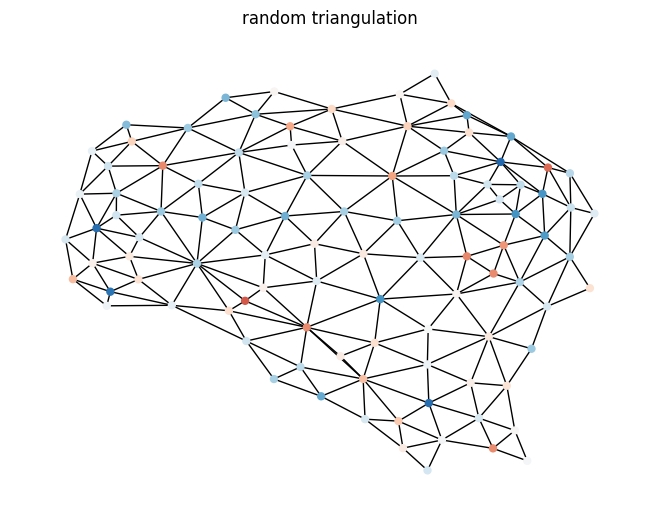

In [ ]:
# spring layout for easier visual
plot_graph = nx.Graph()
plot_graph.add_edges_from(data_extract['triangulation_edges'])
plot_graph.add_nodes_from(data_extract['triangulation_nodes'])

cmap = plt.colormaps['RdBu']

colors = []
for node in plot_graph.nodes():
    # if node == 87:
    #     # colors.append('black')
    #     # colors.append(cmap((mags_per_site[node] + 1)/2))
    # else:
    #     colors.append(cmap((mags_per_site[node] + 1)/2))
    colors.append(cmap((mags_per_site[node] + 1)/2))


pos=nx.spring_layout(plot_graph, k=1, iterations=1000)
nx.draw(plot_graph, pos, node_size = 25, node_color = colors)
plt.title('random triangulation')

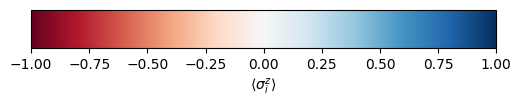

In [ ]:
fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)
cmap = cm.get_cmap('RdBu')
norm = mpl.colors.Normalize(vmin=-1.0, vmax=1.0)
cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                orientation='horizontal')
cb1.set_label(r'$\langle \sigma_i^z \rangle$')
fig.show()